## Semantic Textual Similarity

Source for Dataset: https://www.kaggle.com/datasets/quora/question-pairs-dataset

In [1]:
%pip install sentence_transformers

Note: you may need to restart the kernel to use updated packages.


#### Import Necessary Libraries

In [2]:
import sys, os, math, random, re, logging
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

from sentence_transformers import SentenceTransformer, models, util, losses, LoggingHandler, evaluation, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

#### Versions of Libraries

In [3]:
print("Python:".ljust(10), sys.version[0:6])
print("NumPy:".ljust(10), np.__version__)
print("Pandas:".ljust(10), pd.__version__)
print("Torch:".ljust(10), torch.__version__)
print("Sklearn:".ljust(10), sklearn.__version__)

Python:    3.9.12
NumPy:     1.25.0
Pandas:    2.0.2
Torch:     2.0.1
Sklearn:   1.2.2


#### Ingest & Preprocess Dataset

In [4]:
cols2use = [
    'qid1', 
    'qid2', 
    'question1', 
    'question2', 
    'is_duplicate'
    ]

col_types = {
    'qid1': np.int32, 
    'qid2': np.int32, 
    'question1' : str, 
    'question2' : str, 
    'is_duplicate': np.int32
    }

data = pd.read_csv('questions.csv', 
                   usecols=cols2use, 
                   dtype=col_types)

data = data.rename(columns=
                   {
                       'question1' : 'q1', 
                       'question2' : 'q2', 
                       'is_duplicate' : 'labels'
                    }
                )

data = data.dropna()
data = data.drop_duplicates()

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404348 entries, 0 to 404350
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   qid1    404348 non-null  int32 
 1   qid2    404348 non-null  int32 
 2   q1      404348 non-null  object
 3   q2      404348 non-null  object
 4   labels  404348 non-null  int32 
dtypes: int32(3), object(2)
memory usage: 13.9+ MB


#### Visualize: Length of First Question (in Words) by Class

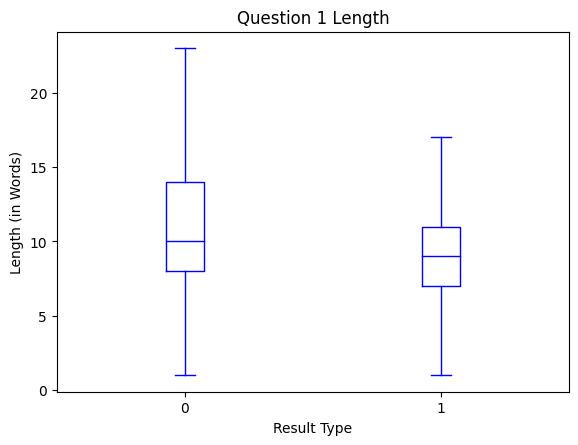

In [5]:
data['q1_len'] = data['q1'].str.split().apply(len)

data.boxplot("q1_len", by="labels", grid=False, showfliers=False, color="Blue")
plt.suptitle('')
plt.title('Question 1 Length')
plt.xlabel('Result Type')
plt.ylabel('Length (in Words)')
plt.show()

data.drop(columns=['q1_len'], inplace=True)

#### Visualize: Length of Second Question (in Words) by Class

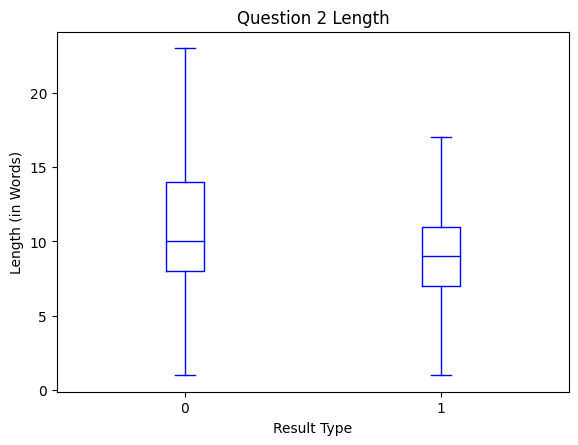

In [6]:
data['q2_len'] = data['q2'].str.split().apply(len)

data.boxplot("q2_len", by="labels", grid=False, showfliers=False, color="Blue")
plt.suptitle('')
plt.title('Question 2 Length')
plt.xlabel('Result Type')
plt.ylabel('Length (in Words)')
plt.show()

data.drop(columns=['q2_len'], inplace=True)

#### Create Function to Visualize Class Distribution (Barplot)

In [7]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   rotation: np.uint8 = 0,
                   annotations: bool = True,

                   ):
    """
    This function returns a histogram for a feature.

    Inputs:
    - feature_to_visualize: Feature to plot in the form
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.
    - rotation: Integer value of the rotation of x-tick
        values
    - annotations: If count of each unique value in
        feature is included in visualization

    Output:
    - A Bar Plot.
    """

    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
    assert type(rotation) != np.uint8, \
        "The rotation value must be between 0 and 255."

    ax = feature_to_visualize.value_counts().plot.bar(
                                                      figsize=(12,8),
                                                      rot=rotation,
                                                      legend=False,
                                                      color=["lightgreen",
                                                             "blue",
                                                             "brown",
                                                             "lightblue",
                                                             "tan",
                                                             "yellow",
                                                             "orange",
                                                             "green",
                                                             "red",
                                                             "purple"]
                                                      )
    if annotations:
        ax.bar_label(ax.containers[0])

    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.show()

#### Visualize Class Distribution

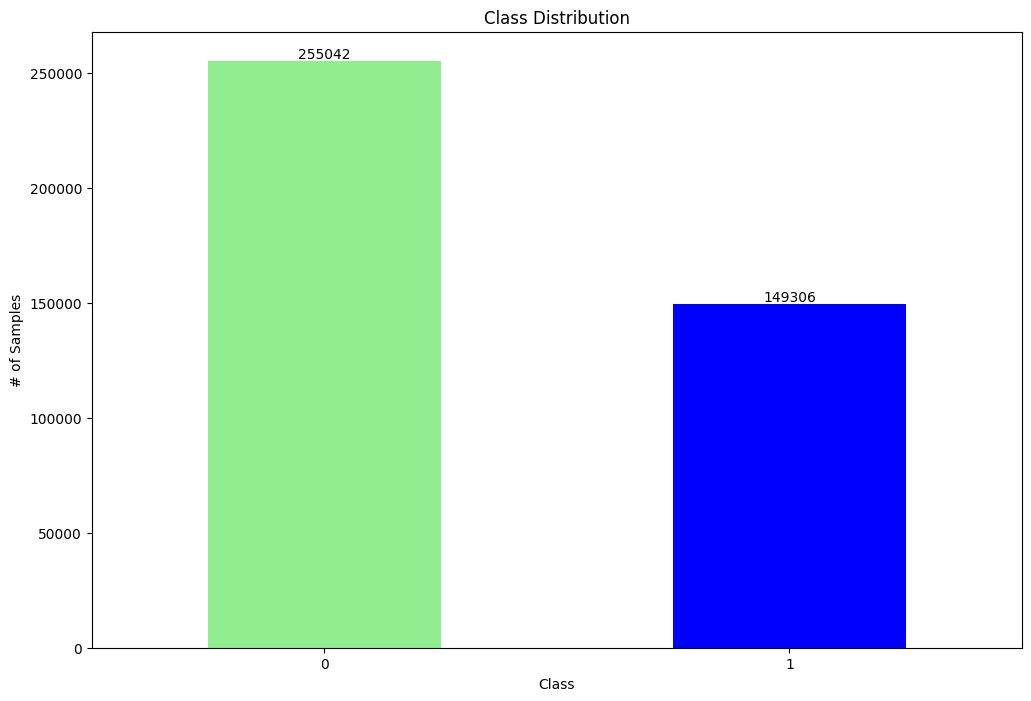

In [8]:
barplot_visual(data["labels"],
               "Class Distribution",
               "Class",
               "# of Samples")

#### Train/Eval Split

In [9]:
train_ds, eval_ds = train_test_split(data, test_size=0.20, random_state=42)

print(f"Training Data Shape: {train_ds.shape}")
print(f"Evaluation Data Shape: {eval_ds.shape}")

Training Data Shape: (323478, 5)
Evaluation Data Shape: (80870, 5)


#### Instantiate Logging Function

In [10]:
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)

#### Encode Dataset & Instantiate the Model

In [31]:
model_ckpt = "sentence-transformers/sentence-t5-large"
device=torch.device("cpu")

model = SentenceTransformer(model_ckpt, device=device)
model.max_seq_length = 34

embeddings = model.encode(['q1', 'q2'], show_progress_bar=True)

distance_metric = losses.SiameseDistanceMetric.COSINE_DISTANCE

margin = 0.50

num_of_epochs = 1

training_batch_size = 64
testing_batch_size = 16

model_save_path = f"{model_ckpt.split('/')[-1]}-FT-Quora_Sentence_Similarity-400"

dataset_path = '/Users/briandunn/Desktop/Semantic Similarity/nlp_ch4/sentence-t5-large-FT-Quora_Sentence_Similarity-400'
os.makedirs(model_save_path, exist_ok=True)

2023-06-26 00:10:16 - Load pretrained SentenceTransformer: sentence-transformers/sentence-t5-large


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

#### Assign Training Samples to DataLoader (InputExample)

In [12]:
train_samples = []

for index, row in train_ds.iterrows():
    sample = InputExample(texts=[row['q1'], row['q2']], label=int(row['labels']))
    train_samples.append(sample)

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=training_batch_size)
train_loss = losses.OnlineContrastiveLoss(model=model, distance_metric=distance_metric, margin=margin)

#### Set Up Validation Dataset

In [13]:
dev_sentences1 = []
dev_sentences2 = []
dev_labels = []

for index, row in eval_ds.iterrows(): 
    dev_sentences1.append(row['q1'])
    dev_sentences2.append(row['q2'])
    dev_labels.append(row['labels'])

#### Create Function to Compute Metrics

In [14]:
binary_acc_evaluator = evaluation.BinaryClassificationEvaluator(dev_sentences1, 
                                                                dev_sentences2, 
                                                                dev_labels, 
                                                                show_progress_bar=True, 
                                                                batch_size=testing_batch_size,
                                                                name="Quora_Sentence_Similarity_Metrics-400",
                                                                write_csv=True)

#### Train Model

In [15]:
model.fit(train_objectives=[(train_dataloader, train_loss)],  
          evaluator = binary_acc_evaluator, 
          epochs=num_of_epochs, 
          warmup_steps=20,
          output_path=model_save_path, 
          show_progress_bar=True,
          checkpoint_path='checkpoints_400/', 
          checkpoint_save_steps=500,
          checkpoint_save_total_limit=10)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5055 [00:00<?, ?it/s]

2023-06-22 18:50:39 - Save model to checkpoints_400/500
2023-06-23 03:05:59 - Save model to checkpoints_400/1000
2023-06-23 11:09:38 - Save model to checkpoints_400/1500
2023-06-23 19:18:03 - Save model to checkpoints_400/2000
2023-06-24 03:10:58 - Save model to checkpoints_400/2500
2023-06-24 10:59:04 - Save model to checkpoints_400/3000
2023-06-24 19:04:19 - Save model to checkpoints_400/3500
2023-06-25 03:06:55 - Save model to checkpoints_400/4000
2023-06-25 11:09:41 - Save model to checkpoints_400/4500
2023-06-25 19:32:27 - Save model to checkpoints_400/5000
2023-06-25 20:25:13 - Binary Accuracy Evaluation of the model on Quora_Sentence_Similarity_Metrics-400 dataset after epoch 0:


Batches:   0%|          | 0/8598 [00:00<?, ?it/s]

2023-06-25 23:53:38 - Accuracy with Cosine-Similarity:           88.72	(Threshold: 0.8397)
2023-06-25 23:53:38 - F1 with Cosine-Similarity:                 85.22	(Threshold: 0.8223)
2023-06-25 23:53:38 - Precision with Cosine-Similarity:          80.72
2023-06-25 23:53:38 - Recall with Cosine-Similarity:             90.25
2023-06-25 23:53:38 - Average Precision with Cosine-Similarity:  89.75

2023-06-25 23:53:38 - Accuracy with Manhattan-Distance:           88.71	(Threshold: 12.4351)
2023-06-25 23:53:38 - F1 with Manhattan-Distance:                 85.22	(Threshold: 13.2209)
2023-06-25 23:53:38 - Precision with Manhattan-Distance:          80.58
2023-06-25 23:53:38 - Recall with Manhattan-Distance:             90.42
2023-06-25 23:53:38 - Average Precision with Manhattan-Distance:  89.74

2023-06-25 23:53:38 - Accuracy with Euclidean-Distance:           88.72	(Threshold: 0.5662)
2023-06-25 23:53:38 - F1 with Euclidean-Distance:                 85.22	(Threshold: 0.5962)
2023-06-25 23:53:

#### Saving Model to HuggingFace Hub (My Profile)

In [ ]:
model.save_to_hub(model_save_path, private=True)

### Notes & Other Takeaways From This Project

****
- I ran into an error that with uploading the project to the HuggingFace Hub. I am pretty sure that I was able to find the fix (to upgrade the HuggingFace Hub library version- which I did), but in order for it to work ,I would have had to restart the kernel (and thus, retrain the entire project). To make this work without retraining the entire project, I just manually uploaded the project files to the Hub!

- Also, I cleared out the error to keep everything looking clean!

****

### Citation

- Model Checkpoint

    > Jianmo Ni, Gustavo Hernandez Abrego, Noah Constant, Ji Ma, Keith Hall, Daniel Cer, and Yinfei Yang. 2022. Sentence-T5: Scalable Sentence Encoders from Pre-trained Text-to-Text Models. In Findings of the Association for Computational Linguistics: ACL 2022, pages 1864–1874, Dublin, Ireland. Association for Computational Linguistics.